# Concept Drift and How Things Go Wrong

- skip_exec: true


In [ ]:
from pathlib import Path

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, roc_auc_score, log_loss
from torch.utils.data import Dataset, DataLoader
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0

PROJECT_ROOT = Path.cwd().parent.parent

## Introduction


Drift is where the patterns that we see in our training data do not hold after the model goes into production. There are two main types of drift.

- **Concept Drfit**: The relationship between the input and target changes
- **Covariate Shift**: The distribution of the input feautures changes

A more mathmatical way of thinking about these two types of drift is that given a "data generating function" $y = f(x)$, concept drift is a change in $f$ and covariate shift is a change in the distribution of $x$. We can also visualise this difference:


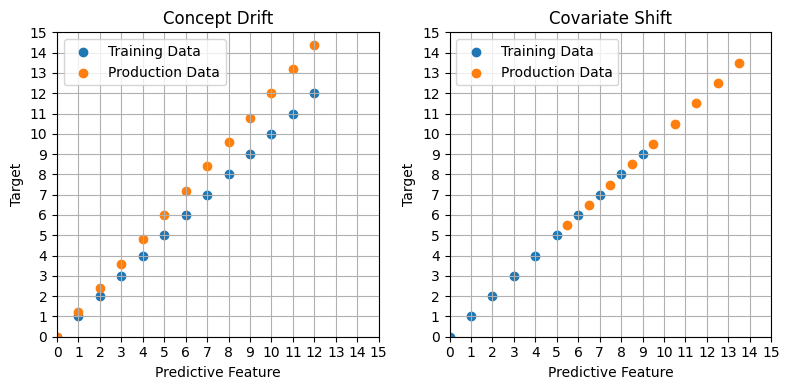

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.flatten()

xs = np.arange(0, 13, 1)
ys_1 = xs
ys_2 = xs * 1.2

ax[0].scatter(xs, ys_1, label="Training Data")
ax[0].scatter(xs, ys_2, label="Production Data")
ax[0].set_title("Concept Drift")

xs_1 = np.arange(0, 10, 1)
xs_2 = np.arange(5.5, 14.5, 1)
ys_1 = xs_1
ys_2 = xs_2

ax[1].scatter(xs_1, ys_1, label="Training Data")
ax[1].scatter(xs_2, ys_2, label="Production Data")
ax[1].set_title("Covariate Shift")

for a in ax:
    a.set_xlim(0, 15)
    a.set_ylim(0, 15)
    a.set_xticks(np.arange(0, 16, 1))
    a.set_yticks(np.arange(0, 16, 1))
    a.set_xlabel("Predictive Feature")
    a.set_ylabel("Target")
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

## Detecting Drift


Two ways to detect drift are:

- Monitoring the descriptive statistics in you data over time
- Backtesting, where you train you model on a certain time period and then validate it on a later time period
- Using your intuition and domain knowledge to be aware of when things might be different

We'll use the Grupo Bimbo dataset to illustrate how to detect drift


In [ ]:
all_data = pd.read_csv(f"{PROJECT_ROOT}/data/grupo-bimbo-inventory-demand/train.csv", low_memory=True)
print(all_data.shape)
all_data.head()


(74180464, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


One way in which this data changes over time in the presence of absence of gaps. This can lead to compositional changes which may affect the performance of your model or the patterns it identifies when train. You would want to investigate how these gaps occur to see if they contain a useful signal, are merely noise, or if there is a way to mitigate their effect.

For this demo we will mitigate some of their effect by just looking at a single product ID.


In [ ]:
product_data = all_data.query("Producto_ID == 1238")
print(product_data.shape)
product_data.head()


(1191873, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
95,3,1110,7,3301,198780,1238,9,88.47,0,0.0,9
153,3,1110,7,3301,988589,1238,1,9.83,0,0.0,1
169,3,1110,7,3301,1159580,1238,6,58.98,0,0.0,6
189,3,1110,7,3301,1163700,1238,3,29.49,0,0.0,3


This doesn't get rid of the compositional shift entirely. We can see that the number of locations where this product is appearing seems to be decreasing week on week.


In [ ]:
product_data["Semana"].value_counts().sort_index()


Semana
3    194927
4    181975
5    171431
6    166625
7    164743
8    158032
9    154140
Name: count, dtype: int64

Looking further at the data we can see that most locations do not have a record of this product in every week. 75% have 5 weeks of fewer worth of records. To further reduce the compositional shift we will just look at locations that have a record of the full 7 weeks.


In [ ]:
store_product_group_cols = ["Agencia_ID", "Canal_ID", "Ruta_SAK", "Cliente_ID"]
store_product_value_counts = product_data.groupby(store_product_group_cols).size()
store_product_value_counts.describe()

count    372501.000000
mean          3.199650
std           1.983802
min           1.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           7.000000
dtype: float64

In [ ]:
full_filled_data = product_data.set_index(store_product_group_cols).loc[(store_product_value_counts == 7)]
full_filled_data.reset_index(inplace=True)

print(full_filled_data.shape)
full_filled_data.head()


(288617, 11)


,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Semana,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,1110,7,3301,15766,3,1238,4,39.32,0,0.0,4
1,1110,7,3301,1159580,3,1238,6,58.98,0,0.0,6
2,1110,7,3301,1163700,3,1238,3,29.49,0,0.0,3
3,1110,7,3301,1307034,3,1238,3,29.49,0,0.0,3
4,1110,7,3301,1682456,3,1238,3,29.49,0,0.0,3


After all that filtering, we can see that the average demand has declined over time from ~5.4 to ~4.6.


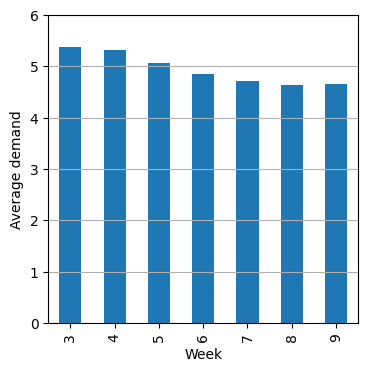

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
full_filled_data.groupby(["Semana"])["Demanda_uni_equil"].mean().plot(kind="bar", ax=ax)
ax.set_ylim(0, 6)
ax.grid(axis="y")
ax.set_xlabel("Week")
ax.set_ylabel("Average demand")
plt.show()

## Backtesting


The next thing we are going to do is train a set of models where each model is trained on one week and validated on data from the next week.

If each model performs similarly well that would indicate less drift. If however the performance varies a lot that would suggest that the validation score we have for a model trained on the full dataset may not be a good indicator of how it will perform in the future.


### Modelling


In [ ]:
categorical_cols = ["Agencia_ID", "Canal_ID", "Ruta_SAK", "Cliente_ID", "Producto_ID"]
numerical_cols = ["Venta_uni_hoy", "Venta_hoy"]

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, num_unique_vals, hidden_size=128, num_features=2):
        super(SimpleModel, self).__init__()
        embedding_size = 50
        self.embeddings = nn.ModuleList(
            [nn.Embedding(num_unique_vals[col], embedding_size) for col in categorical_cols]
        )
        self.num_layer = nn.Linear(num_features, embedding_size)
        self.fc1 = nn.Linear(embedding_size * len(num_unique_vals) + embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x_cat, x_num):
        x_cat = [embedding(x_i.clip(0)) for x_i, embedding in zip(x_cat, self.embeddings)]
        x_cat = torch.cat(x_cat, dim=-1)
        x_num = torch.relu(self.num_layer(x_num))
        x = torch.cat([x_cat, x_num], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x).squeeze(-1)
        return x


In [ ]:
def train(train_dataset, val_dataset, num_unique_vals):
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    num_epochs = 5
    loss_fn = nn.MSELoss()
    model = SimpleModel(num_unique_vals)
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    for _ in range(num_epochs):
        model.train()
        train_loss = 0.0
        for (inputs_cat, inputs_num), targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs_cat, inputs_num).squeeze()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

    model.eval()
    val_loss, val_preds, val_targets = 0.0, [], []
    with torch.no_grad():
        for (inputs_cat, inputs_num), targets in val_loader:
            outputs = model(inputs_cat, inputs_num).squeeze()
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            val_preds.extend(outputs.tolist())
            val_targets.extend(targets.tolist())
    val_loss /= len(val_loader)
    return model, val_loss


In [ ]:
class BimboDataset(Dataset):
    def __init__(self, X_cat, X_num, y):
        self.X_cat = [torch.tensor(X_cat[:, i], dtype=torch.long) for i in range(X_cat.shape[1])]
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x_cat = [x[idx] for x in self.X_cat]
        x_num = self.X_num[idx]
        y = self.y[idx]
        return (x_cat, x_num), y


In [ ]:
def make_models(data):
    num_unique_vals = {col: data[col].nunique() for col in categorical_cols}
    data = data.sort_values("Semana")

    X_categorical = data[categorical_cols].values
    X_numerical = data[numerical_cols].values
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_categorical = encoder.fit_transform(X_categorical)
    y = data["Demanda_uni_equil"].values

    weeks = sorted(data["Semana"].unique())

    model_list, metric_list = [], []
    for training_week in weeks[:-1]:
        val_week = training_week + 1
        train_index = data[data["Semana"] == training_week].index
        val_index = data[data["Semana"] == val_week].index

        X_train_cat, X_val_cat = X_categorical[train_index], X_categorical[val_index]
        X_train_num, X_val_num = X_numerical[train_index], X_numerical[val_index]
        y_train, y_val = y[train_index], y[val_index]
        train_dataset = BimboDataset(X_train_cat, X_train_num, y_train)
        val_dataset = BimboDataset(X_val_cat, X_val_num, y_val)

        model, val_loss = train(train_dataset, val_dataset, num_unique_vals)
        metrics = {"training_data_week": training_week, "validation_data_week": val_week, "validation_loss": val_loss}
        model_list.append(model)
        metric_list.append(metrics)
    return model_list, encoder, metric_list

In [ ]:
models, encoder, metrics = make_models(full_filled_data)

We can see here a week where the a model performs much worse. This is the sort of thing you want to investigate in search of drift.


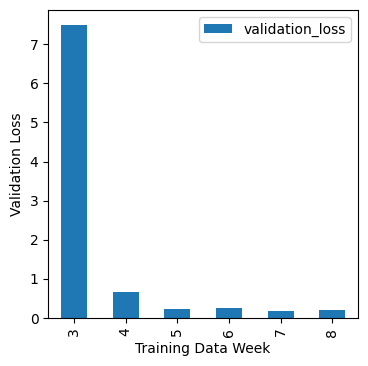

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.DataFrame(metrics).plot(kind="bar", x="training_data_week", y="validation_loss", ax=ax)
ax.set_xlabel("Training Data Week")
ax.set_ylabel("Validation Loss")
plt.show()


## Understanding covariate shift


Although covariate shift does not mean the relationship between the input and target has change, it can still cause problems as your model will now being seeing data in a different area from where it learned that relationship.

If you think you have covariate shift in your data it is worth thinking about how you may need to update your simulation as a result. For example, if you have more high income people going forward and they are known to purchase things more frequently, it may be worth thinking about ways to "hard code" that in your simulation.


## Understanding concept drift


We'll use the telco customer churn dataset to illustrate this.


In [ ]:
data = pd.read_csv(f"{PROJECT_ROOT}/data/WA_Fn-UseC_-Telco-Customer-Churn.csv", low_memory=False)
print(data.shape)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We can start by training the model normally


In [ ]:
target = "Churn"
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1), data[target] == "Yes", test_size=0.2, random_state=0
)
cols_to_use = [
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
]

preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), make_column_selector(dtype_include="object"))],
    remainder="passthrough",  # Leave numerical variables unchanged
)

pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier())])
pipeline.fit(X_train[cols_to_use], y_train)
y_pred = pipeline.predict_proba(X_test[cols_to_use])[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
log_loss_val = log_loss(y_test, y_pred)


We'll now write a baseline prediction function which simply returns the predicted probability of churn from the model.


In [ ]:
def baseline_prediction(data):
    return pipeline.predict_proba(data[cols_to_use])[:, 1]

Now we might have some intuition that DSL customers are more likely to churn than the model would predict based on the historic training data. May there has been a recent development in the news or the telco market which we would like to take into account.

In this case we could do something like update our prediction function to add a 10% increase in the probability of churn for DSL customers. 10% is a very arbitrary number here. It may be possible to come up with a strong justification for a particular number. However, even if you can't it is always worth considering at least adjusting somewhat in the direction you think your business is about to move.


In [ ]:
def prediction_adjust_DSL(data):
    baseline = baseline_prediction(data)
    has_DSL = data["InternetService"] == "DSL"
    out = baseline + has_DSL * 0.1
    out = np.clip(out, 0, 1)
    return out

## Adjusting concept drift with Shap


As well as adjusting the model's predictions for subsets of the population, it is also possible to adjust the contribution a feature makes to the prediction in the first place. We can do this by using the Shap library to calculate the Shapley values for each feature and then adjusting them based on our intuition.

For instance, in this example we have fitted a TreeExplainer from the Shap library. We have then created a custom prediction function which will reduce the effect of customer's tenure on the prediction probability that they will churn by half.


In [ ]:
encoded_value = pipeline.named_steps["preprocessor"].transform(X_train[cols_to_use])
explainer = shap.TreeExplainer(pipeline.named_steps["classifier"], data=encoded_value)


In [ ]:
def prediction_with_less_effect_for_tenure(data):
    tenure_column = 0
    effect_reduction_size = 0.5

    prediction = baseline_prediction(data)
    encoded_data = pipeline.named_steps["preprocessor"].transform(data[cols_to_use])
    shap_values = explainer.shap_values(encoded_data)
    effect_for_tenure = shap_values[:, tenure_column]
    adjusted_predictions = prediction - effect_for_tenure * effect_reduction_size
    adjusted_predictions = np.clip(adjusted_predictions, 0, 1)
    return adjusted_predictions


We can get a high level visual impression of how these adjustments affect our predictions. You would probably want to do further analysis and monitor how these predictions would interact with your business decisions before putting them into production.


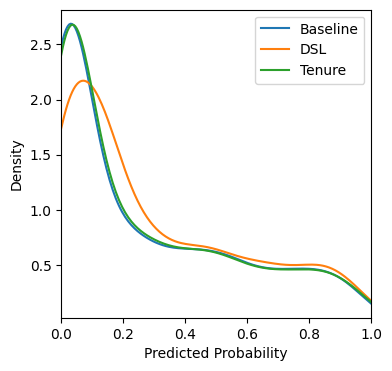

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(baseline_prediction(X_test), label="Baseline", ax=ax, clip=(0.0, 1.0))
sns.kdeplot(prediction_adjust_DSL(X_test), label="DSL", ax=ax, clip=(0.0, 1.0))
sns.kdeplot(prediction_with_less_effect_for_tenure(X_test), label="Tenure", ax=ax, clip=(0.0, 1.0))

ax.set_xlim(0, 1)
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Density")
ax.legend()
plt.show()

## The Sim2Real Problem


How should you make sure your simulation is useful in the real world?

- Make it better!
- Think of it like overfitting. Simpler decision frameworks are likely more robust
- Validate it with people close to the existing process
- Test it on a small scale first e.g. AB Testing

When designing a test it is important to randomise but also to minimise "contamination".

For instance, you might give a random set of people across all geographies a discount. However, if people who don't get a discount see this going on they may react negatively which will affect your results. You could instead give a whole geography a discount and not another. However now you have reduced your randomisation.

You could randomise a store's decision rule week by week. However, if the rule they followed last week will affect their behaviour this week you have again created contamination in your results.

Trading these forces off against each other is a key part of designing a good test.


## Simulate - Optimise - Test


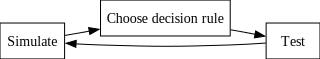

In [ ]:
s = """
Simulate[shape=box label="Simulate"]
Decision[shape=box label="Choose decision rule"]
Test[shape=box label="Test"]
Simulate->Decision
Decision->Test
Test->Simulate
"""
graphviz.Source(f'digraph G{{rankdir="LR"; margin=0; pad=0; bgcolor="transparent"; {s}}}')

## References


- [Machine Learning for Business Decision Optimization](https://www.wandb.courses/courses/decision-optimization) - Dan Becker
